In [1]:
import pandas as pd
import numpy as np
import time
import random
import os
from os.path import join

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
plt.style.use(join("..", "model_fitting", 'CCB_plot_style_0v4.mplstyle'))
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   #fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000'] 


Bad key text.latex.preview in file ..\model_fitting\CCB_plot_style_0v4.mplstyle, line 55 ('text.latex.preview  : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file ..\model_fitting\CCB_plot_style_0v4.mplstyle, line 63 ('mathtext.fallback_to_cm : True ## When True, use symbols from the Computer Modern fonts')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


## 1. Loading data from TCDB, Unirpot, and GOA database and merging them:

### (a) Loading database created from TCDB:

In [2]:
df_TCDB = pd.read_csv(join("..", "..", "data", "TCDB", "database_without_inchi.csv"))
df_TCDB.drop(columns = ["TCNumber", "Name", "Substrate"], inplace = True)
df_TCDB["GOA"] = 0
df_TCDB["TCDB"] = 1
df_TCDB["SWISS"] = 0
display(df_TCDB.head(2))
print(len(df_TCDB))
print("Number of different sequences: %s\
\nNumber of different CHEBI IDs: %s\
\nNumber of different Uniprot IDs: %s" 
      % (len(set(list(df_TCDB["Sequence"]))), len(set(list(df_TCDB["ChEBI"]))),len(set(list(df_TCDB["UniProt"])))))

,UniProt,Sequence,ChEBI,GOA,TCDB,SWISS
0,P0A334,MPPMLSGLLARLVKLLLGRHGSALHWRAAGAATVLLVIVLLAGSYL...,CHEBI:8345,0,1,0
1,P0A334,MPPMLSGLLARLVKLLLGRHGSALHWRAAGAATVLLVIVLLAGSYL...,CHEBI:5585,0,1,0


18051
Number of different sequences: 11795
Number of different CHEBI IDs: 1559
Number of different Uniprot IDs: 11799


### (b) Loading database created from GOA:

In [3]:
df_GOA = pd.read_pickle(join("..", "..", "data", "GOA", "GOA_Transporter.pkl"))
df_GOA.rename(columns = {"Uniprot ID" : "UniProt", "molecule ID" : "ChEBI"}, inplace = True)
df_GOA["GOA"] = 1
df_GOA["TCDB"] = 0
df_GOA["SWISS"] = 0
display(df_GOA.head(2))
print(len(df_GOA))
print("Number of different sequences: %s\
\nNumber of different ChEBI IDs: %s\
\nNumber of different Uniprot IDs: %s" 
      % (len(set(list(df_GOA["Sequence"]))), len(set(list(df_GOA["ChEBI"]))),len(set(list(df_GOA["UniProt"]))) ))

,UniProt,ChEBI,Sequence,GOA,TCDB,SWISS
0,O14031,CHEBI:5437,MTARNSASIPTSIRKTSENEVSGDETPAGVGNLSTKTASKTSLTFR...,1,0,0
1,O14329,CHEBI:10113,MTQNHNIPTAIQIQNPINNNVSVTISDQLPKPSANNPNLLSVDTRP...,1,0,0


4775
Number of different sequences: 3371
Number of different ChEBI IDs: 281
Number of different Uniprot IDs: 3420


### (c) Loading database created from Uniprot:

In [4]:
df_Uniprot = pd.read_pickle(join("..",  "..", "data", "Uniprot", "Transporter_Uniprot.pkl"))
df_Uniprot.rename(columns = {"Uniprot ID" : "UniProt", "molecule ID" : "ChEBI"}, inplace = True)
df_Uniprot["GOA"] = 0
df_Uniprot["TCDB"] = 0
df_Uniprot["SWISS"] = 1
display(df_Uniprot.head(2))
print(len(df_Uniprot))
print("Number of different sequences: %s\
\nNumber of different ChEBI IDs: %s\
\nNumber of different Uniprot IDs: %s" 
      % (len(set(list(df_Uniprot["Sequence"]))), len(set(list(df_Uniprot["ChEBI"]))),len(set(list(df_Uniprot["UniProt"]))) ))

,UniProt,ChEBI,Entry,Sequence,GOA,TCDB,SWISS
0,P63361,CHEBI:43474,P63361,MNLMAERSLENAVGEKMNATASSIKMRGEKVCVFYGEKQALFDVDL...,0,0,1
1,Q5LBQ4,CHEBI:43474,Q5LBQ4,MDTTVKIDARDVNFWYGDFHALKGISMEIEEKSVVAFIGPSGCGKS...,0,0,1


15864
Number of different sequences: 10748
Number of different ChEBI IDs: 243
Number of different Uniprot IDs: 12910


### (d) Merging all three datasets:

In [5]:
df_transporter = pd.concat([pd.concat([df_GOA, df_TCDB]), df_Uniprot])
df_transporter = df_transporter.loc[~pd.isnull(df_transporter["ChEBI"])]
df_transporter.drop(columns = ["Entry"], inplace = True)
df_transporter

,UniProt,ChEBI,Sequence,GOA,TCDB,SWISS
0,O14031,CHEBI:5437,MTARNSASIPTSIRKTSENEVSGDETPAGVGNLSTKTASKTSLTFR...,1,0,0
1,O14329,CHEBI:10113,MTQNHNIPTAIQIQNPINNNVSVTISDQLPKPSANNPNLLSVDTRP...,1,0,0
2,O42976,CHEBI:9266,MKEENGFAGFLNTAVNRLSGVLNDTAPTKSQSLKNGVNNEGNRGFS...,1,0,0
3,O74969,CHEBI:5256,MGFKRGKNFTLVMLIFVSMAGWMFGADTGSIGGVTSMRDFRERYAD...,1,0,0
4,O76082,CHEBI:23038,MRDYDEVTAFLGEWGPFQRLIFFLLSASIIPNGFTGLSSVFLIATP...,1,0,0
...,...,...,...,...,...,...
15859,Q8HVW3,CHEBI:15378,MFPMVTEFMNYGQQTVRAARYIGQGFTITLSHANRLPVTIQYPYEK...,0,0,1
15860,Q2MII3,CHEBI:15378,MNSIQFPLLDRTAPNSVISTTLNDLSNWSRLSSLWPLLYGTSCCFI...,0,0,1
15861,A6TAW7,CHEBI:15378,MEISYGRALWRNFLGQSPDWYKLALIIFLIVNPLVFAVAPFVAGWL...,0,0,1
15862,A6TAW7,CHEBI:29101,MEISYGRALWRNFLGQSPDWYKLALIIFLIVNPLVFAVAPFVAGWL...,0,0,1


#### Chekcing for TCDB entries in the UniProt database:

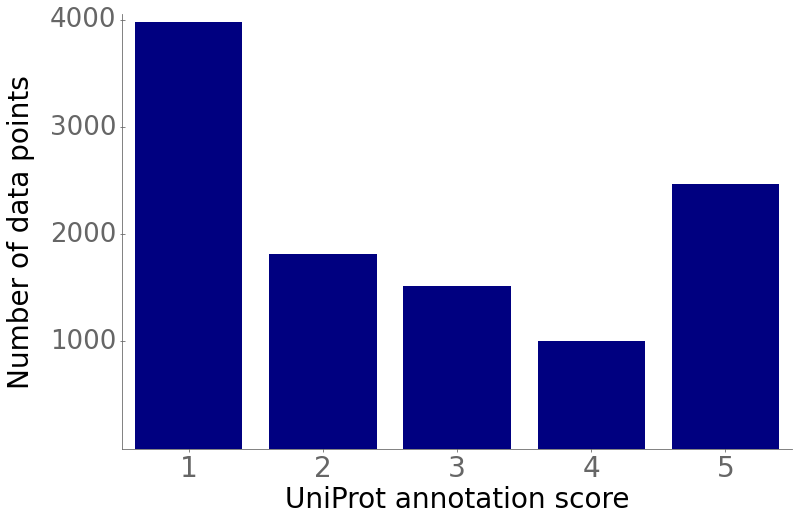

In [8]:
fig, ax = plt.subplots(figsize= (12,8))
plt.rcParams.update({'font.size': 28})

df_TCDB = pd.read_csv(join("..", "..", "data", "TCDB", "database_without_inchi.csv"))
TCDB_UIDs = list(set(df_TCDB["UniProt"]))
TCDB_UIDs

with open("TCDB_UIDs", "w") as file:
    # Write each list item as a line in the file
    file.writelines(item + "\n" for item in TCDB_UIDs)
    
df_tcdb = pd.read_csv(join("..", "..", "data", "tcdb", 
                           "uniprot-download_true_fields_accession_2Ccc_catalytic_activity_2Cgo_-2023.05.16-05.36.44.25.tsv"),
                      sep = "\t")


bins = [1,2,3,4,5]
heights = [len(df_tcdb.loc[df_tcdb["Annotation"] == bins[i]]) for i in range(len(bins))]

ticks = [1000,2000,3000,4000]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks,  y= -0.03, fontsize=26)

plt.bar(bins, height = heights,  color= "navy")

plt.ylabel('Number of data points')
ax.yaxis.set_label_coords(-0.13, 0.5)
plt.xlabel('UniProt annotation score')
plt.savefig(join("..", "..", "figures", "TCDB_annotation_score.svg"))
plt.show()

In [7]:
len(df_tcdb.loc[df_tcdb["Annotation"] <=2])/len(df_tcdb)

0.5375904956376462

Reomving entries from the TCDB:

In [7]:
df_transporter = df_transporter.loc[df_transporter["TCDB"] != 1]
df_transporter

In [9]:
df_Uniprot = pd.DataFrame({"Uniprot ID" : df_transporter["UniProt"],
                          "Sequence" : df_transporter["Sequence"]})

n = len(df_transporter)
df_transporter = df_transporter.groupby(["Sequence", "ChEBI"], as_index= False).mean()

print("We have %s duplciated data points in the databases" % (n -len(df_transporter)))


df_transporter["Uniprot ID"] = [list(df_Uniprot["Uniprot ID"].loc[df_Uniprot["Sequence"] == seq])[0] 
                                for seq in df_transporter["Sequence"]]

We have 2633 duplciated data points in the databases


In [11]:
df_transporter.to_pickle(join("..", "..", "data", "Transporter_merged.pkl"))

In [12]:
print(len(df_transporter))
print("Number of different sequences: %s\
\nNumber of different ChEBI IDs: %s\
\nNumber of different Uniprot IDs: %s" 
      % (len(set(list(df_transporter["Sequence"]))), len(set(list(df_transporter["ChEBI"]))),len(set(list(df_transporter["Uniprot ID"]))) ))

18006
Number of different sequences: 13777
Number of different ChEBI IDs: 509
Number of different Uniprot IDs: 13777
